In [2]:
import os
import gc
import sys
import json
import glob
import random

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import itertools

from imgaug import augmenters as iaa
from sklearn.model_selection import StratifiedKFold, KFold

In [3]:
DATA_DIR = '/kaggle/input'
ROOT_DIR = '/kaggle/working'

NUM_CATS = 46
IMAGE_SIZE = 512

Для решения задачи instance segmentation была выбрана архитектура Mask RCNN
Реализация архитектуры сети вручную довольно сложная, поэтому мы решили использовать готовую библиотеку, которая включает в себя готовую реализацию данной сети Mask RCNN, позволяет настраивать обучение под собственный датасет

In [59]:
!git clone https://www.github.com/matterport/Mask_RCNN.git
os.chdir('Mask_RCNN')

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 111.83 MiB | 33.16 MiB/s, done.
Resolving deltas: 100% (569/569), done.


In [60]:
sys.path.append(f'{ROOT_DIR}/Mask_RCNN')
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

Для того что бы обучить сеть на instance segmentation требуется много времени и данных, поэтому мы использовали подход transfer learning. Использовали веса, которые обучены на датасете COCO и затем дообучили сеть на предоставленных данных

In [61]:
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

COCO_WEIGHTS_PATH = 'mask_rcnn_coco.h5'

^C
--2020-01-26 18:33:24--  https://www.dropbox.com/s/bo1bmj1wd4yovet/mask_rcnn_fashion_0004.h5
Resolving www.dropbox.com (www.dropbox.com)... 162.125.66.1, 2620:100:6022:1::a27d:4201
Connecting to www.dropbox.com (www.dropbox.com)|162.125.66.1|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/bo1bmj1wd4yovet/mask_rcnn_fashion_0004.h5 [following]
--2020-01-26 18:33:24--  https://www.dropbox.com/s/raw/bo1bmj1wd4yovet/mask_rcnn_fashion_0004.h5
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://ucd52e4a8f2021ee83be81edf132.dl.dropboxusercontent.com/cd/0/inline/Aw5wBnJltKYmL662D5BQjI9lJM6Q4Yzxht5QPktbNAd5mjwvDKOXGJbRlTXLNdjbLh5SpAWpix1neHXXqlxVpnuMZrTQRFBeLQ_3i8Z87ipZG0cSEAJI4aWHJExiaMwmBjs/file# [following]
--2020-01-26 18:33:24--  https://ucd52e4a8f2021ee83be81edf132.dl.dropboxusercontent.com/cd/0/inline/Aw5wBnJltKYmL662D5BQjI9lJM6Q4Yzxht5QPktbNAd5mjwvDKOXGJbRlTXLNdjbLh5Sp

Данный класс наследуется от класса Config библиотеки maskrcnn и позволяет сконфигурирровать сеть и процесс ее обучения

In [62]:
class FashionConfig(Config):
    NAME = "fashion"
    NUM_CLASSES = NUM_CATS + 1
    
    GPU_COUNT = 1
    IMAGES_PER_GPU = 4
    
    BACKBONE = 'resnet50'
    
    IMAGE_MIN_DIM = IMAGE_SIZE
    IMAGE_MAX_DIM = IMAGE_SIZE    
    IMAGE_RESIZE_MODE = 'none'
    
    RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)
    
    STEPS_PER_EPOCH = 250
    VALIDATION_STEPS = 50
    
config = FashionConfig()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     4
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 4
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                59
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              none
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE                

# Обработка данных

In [63]:
with open(DATA_DIR/"label_descriptions.json") as f:
    label_descriptions = json.load(f)

label_names = [x['name'] for x in label_descriptions['categories']]

In [64]:
segment_df = pd.read_csv(f'{DATA_DIR}/train.csv')
segment_df['CategoryId'] = segment_df['ClassId'].str.split('_').str[0]

In [65]:
image_df = segment_df.groupby('ImageId')['EncodedPixels', 'CategoryId'].agg(lambda x: list(x))
size_df = segment_df.groupby('ImageId')['Height', 'Width'].mean()
image_df = image_df.join(size_df, on='ImageId')

In [91]:
def resize_image(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)  
    return img

Класс необходимый для описания процесса работы с данными и их подготовки перед обучением модели

In [67]:
class FashionDataset(utils.Dataset):

    def __init__(self, df):
        super().__init__(self)
        
        for i, name in enumerate(label_names):
            self.add_class("fashion", i+1, name)
        
        for i, row in df.iterrows():
            self.add_image("fashion", 
                           image_id=row.name, 
                           path=f'{DATA_DIR}/train/{row.name}', 
                           labels=row['CategoryId'],
                           annotations=row['EncodedPixels'], 
                           height=row['Height'], width=row['Width'])

    def image_reference(self, image_id):
        info = self.image_info[image_id]
        return info['path'], [label_names[int(x)] for x in info['labels']]
    
    def load_image(self, image_id):
        return resize_image(self.image_info[image_id]['path'])

    def load_mask(self, image_id):
        # transform run-length encoding to mask for given image
        images = self.image_info[image_id]
        mask = np.zeros((IMAGE_SIZE, IMAGE_SIZE, len(images['annotations'])))
        labels = []
        
        for i, (segmentation, label) in enumerate(zip(images['annotations'], images['labels'])):
            encoded_pixels = [int(x) for x in segmentation.split()]
            cur_mask = np.zeros(images['height'] * images['width'])

            for j, start_pixel in enumerate(encoded_pixels[::2]):
                cur_mask[start_pixel:start_pixel+encoded_pixels[2 * j + 1]] = 1

            cur_mask = cur_mask.reshape((images['height'], images['width']), order='F')
            mask[:, :, i] = cv2.resize(cur_mask, (IMAGE_SIZE, IMAGE_SIZE))
            labels.append(int(label) + 1)
            
        return mask, np.asarray(labels)

In [68]:
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(image_df, test_size=0.2, random_state=42)

train_dataset = FashionDataset(train_df)
valid_dataset = FashionDataset(valid_df)

train_dataset.prepare()
valid_dataset.prepare()

# Тренировка

In [5]:
lr = 3e-4
epochs = 4

Создание модели и подгрузка предобученных весов. Веса на последних слоях перед выходом сети не инициализируются предобученными весами, так как необходимо обучить сеть конкретно на одежду, а другие объекты не должны быть сегментированы

In [ ]:
model = modellib.MaskRCNN(mode='training', config=config, model_dir=ROOT_DIR)

model.load_weights(COCO_WEIGHTS_PATH, by_name=True, exclude=['mrcnn_class_logits', 'mrcnn_bbox_fc', 'mrcnn_bbox', 'mrcnn_mask'])

In [ ]:
augmentation = iaa.Sequential([
    iaa.Fliplr(0.3)
])

In [ ]:
model.train(train_dataset, valid_dataset,
            learning_rate=lr, 
            epochs=epochs,
            layers='all',
            augmentation=augmentation)

history = model.keras_model.history.history

In [69]:
glob_list = glob.glob(f'./mask_rcnn_fashion_4.h5')
model_path = glob_list[0] if glob_list else ''

This cell defines InferenceConfig and loads the best trained model.

In [70]:
class InferenceConfig(FashionConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

model = modellib.MaskRCNN(mode='inference', 
                          config=inference_config,
                          model_dir=ROOT_DIR)

model_path = f'{ROOT_DIR}/Mask_RCNN/mask_rcnn_fashion_0004.h5'
model.load_weights(model_path, by_name=True)

Loading weights from  /kaggle/working/Mask_RCNN/mask_rcnn_fashion_0004.h5


In [71]:
sample_df = pd.read_csv(f'{DATA_DIR}/sample_submission.csv')
sample_df.head()

ImageId EncodedPixels  ClassId
0  003d41dd20f271d27219fe7ee6de727d.jpg           1 1       23
1  0046f98599f05fd7233973e430d6d04d.jpg           1 1       23
2  004e9e21cd1aca568a8ffc77a54638ce.jpg           1 1       23
3  005b37fce3c0f641d327d95dd832f51b.jpg           1 1       23
4  0094940c58c343b742f48ae26eb5e9fa.jpg           1 1       23

In [72]:
def to_rle(bits):
    # convert mask to run-length encoding
    rle = []
    pos = 0
    for bit, group in itertools.groupby(bits):
        group_list = list(group)
        if bit:
            rle.extend([pos, sum(group_list)])
        pos += len(group_list)
    return rle

In [73]:
# Since the submission system does not permit overlapped masks, we have to fix them
def refine_masks(masks, rois):
    areas = np.sum(masks.reshape(-1, masks.shape[-1]), axis=0)
    mask_index = np.argsort(areas)
    union_mask = np.zeros(masks.shape[:-1], dtype=bool)
    for m in mask_index:
        masks[:, :, m] = np.logical_and(masks[:, :, m], np.logical_not(union_mask))
        union_mask = np.logical_or(masks[:, :, m], union_mask)
    for m in range(masks.shape[-1]):
        mask_pos = np.where(masks[:, :, m]==True)
        if np.any(mask_pos):
            y1, x1 = np.min(mask_pos, axis=1)
            y2, x2 = np.max(mask_pos, axis=1)
            rois[m, :] = [y1, x1, y2, x2]
    return masks, rois

In [92]:
sub_list = []
missing_count = 0
for i, row in sample_df.iterrows():
    image = resize_image(f"{DATA_DIR}/test/{row['ImageId']}")
    if image is None:
        print(f"{DATA_DIR}/test/{row['ImageId']}")
        sub_list.append([row['ImageId'], '1 1', 23])
        missing_count += 1
    else:
        result = model.detect([image])[0]
        if result['masks'].size > 0:
            masks, _ = refine_masks(result['masks'], result['rois'])
            for m in range(masks.shape[-1]):
                mask = masks[:, :, m].ravel(order='F')
                rle = to_rle(mask)
                label = result['class_ids'][m] - 1
                sub_list.append([row['ImageId'], ' '.join(list(map(str, rle))), label])
        else:
            sub_list.append([row['ImageId'], '1 1', 23])
            missing_count += 1

In [93]:
submission_df = pd.DataFrame(sub_list, columns=sample_df.columns.values)
submission_df.head()

                                ImageId   ...   ClassId
0  003d41dd20f271d27219fe7ee6de727d.jpg   ...        31
1  003d41dd20f271d27219fe7ee6de727d.jpg   ...        31
2  003d41dd20f271d27219fe7ee6de727d.jpg   ...        23
3  003d41dd20f271d27219fe7ee6de727d.jpg   ...        31
4  003d41dd20f271d27219fe7ee6de727d.jpg   ...        31

[5 rows x 3 columns]

In [94]:
submission_df.to_csv("submission.csv", index=False)

Визуализация результатов работы модели на некоторых изображениях

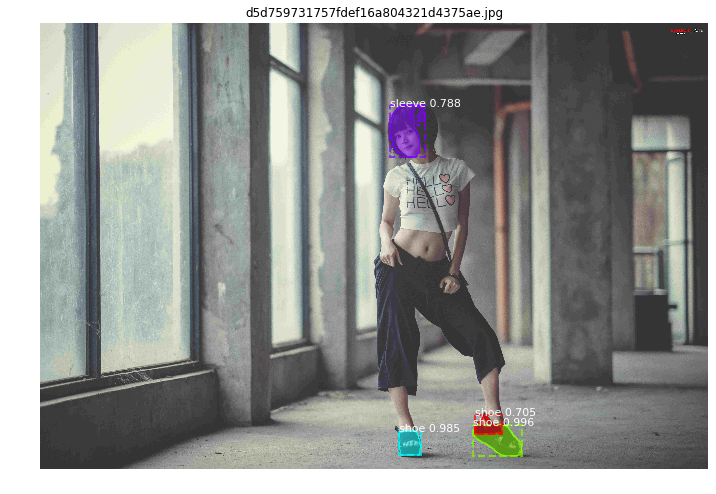

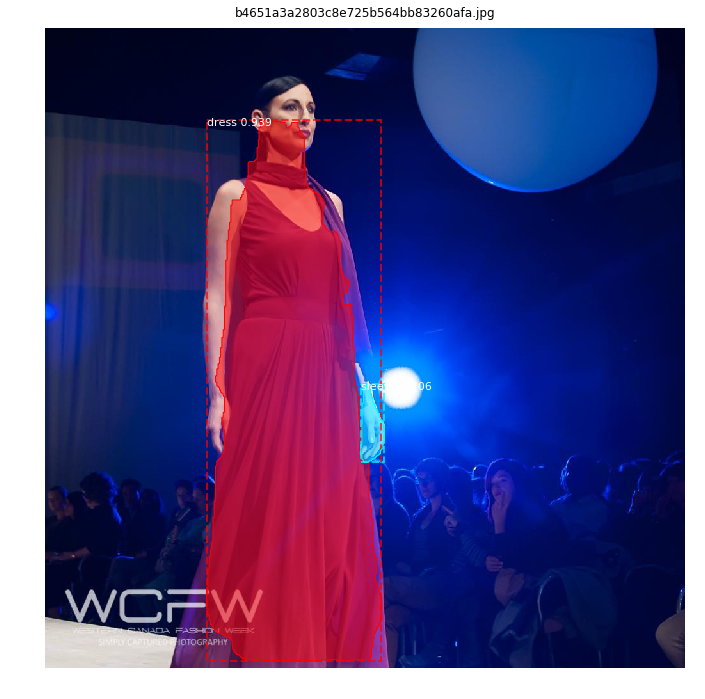

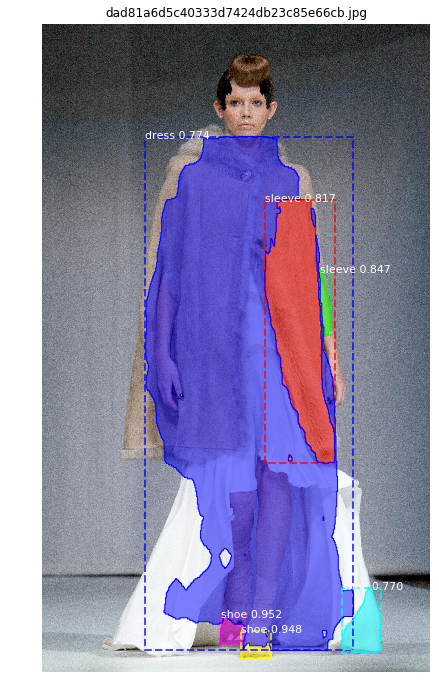

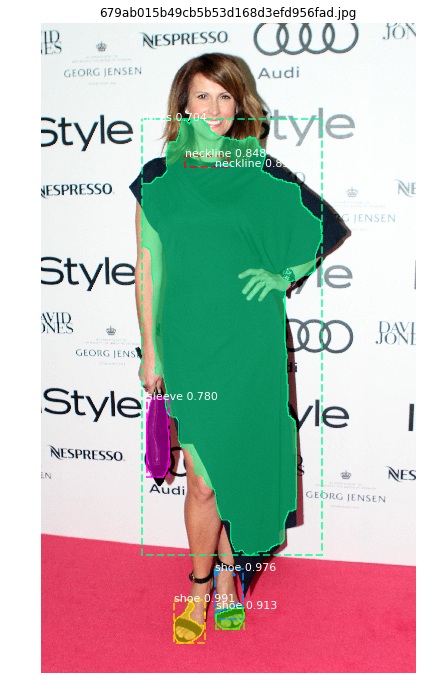

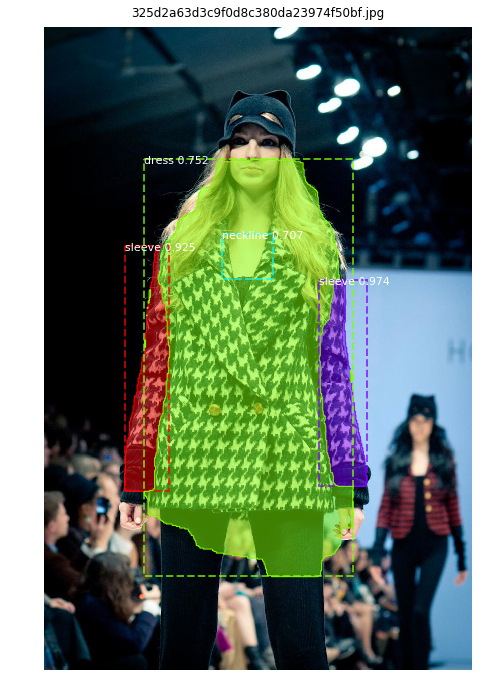

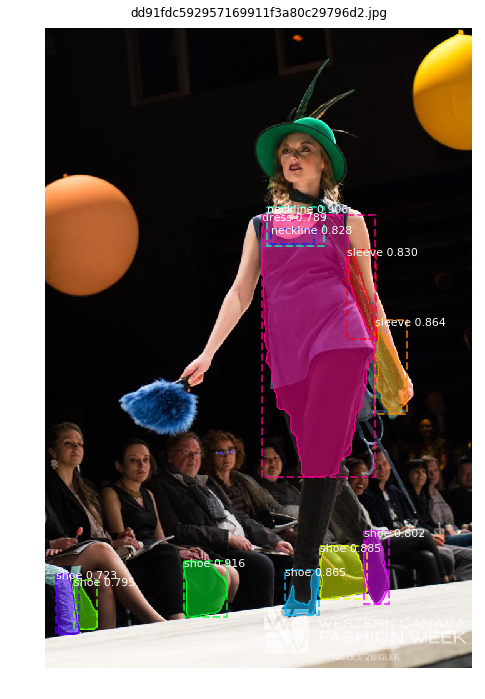

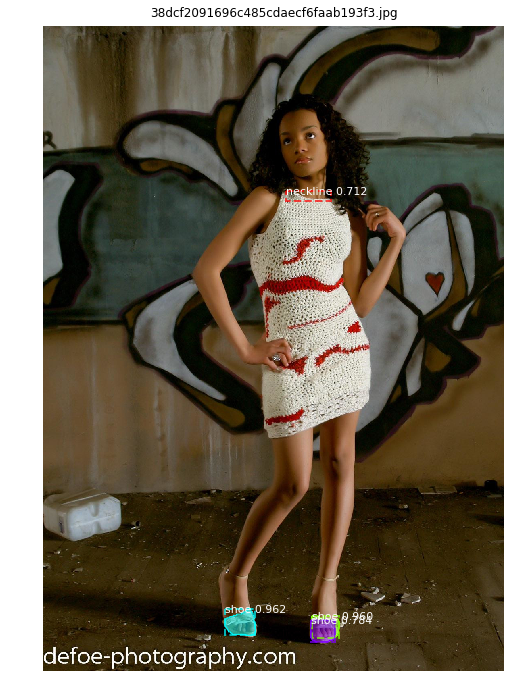

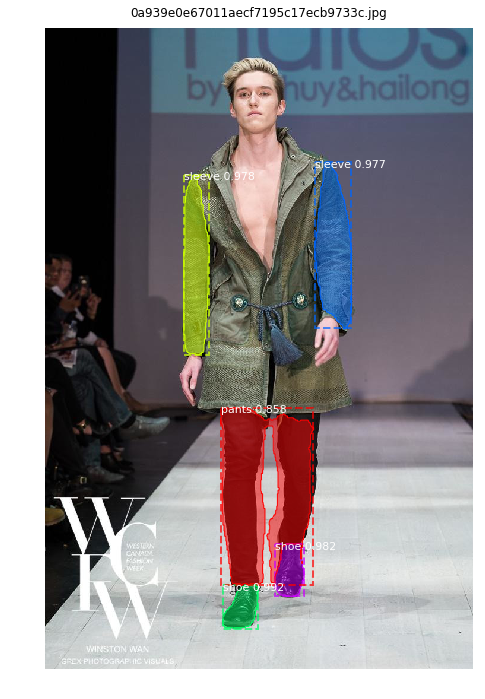

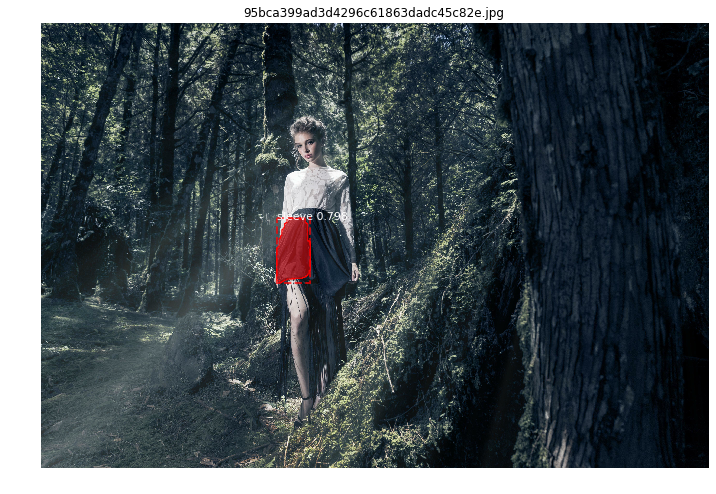

In [95]:
for i in range(9):
    image_id = sample_df.sample()['ImageId'].values[0]
    image_path = str(DATA_DIR/'test'/image_id)
    
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    result = model.detect([resize_image(image_path)])
    r = result[0]
    
    if r['masks'].size > 0:
        masks = np.zeros((img.shape[0], img.shape[1], r['masks'].shape[-1]), dtype=np.uint8)
        for m in range(r['masks'].shape[-1]):
            masks[:, :, m] = cv2.resize(r['masks'][:, :, m].astype('uint8'), 
                                        (img.shape[1], img.shape[0]), interpolation=cv2.INTER_NEAREST)
        
        y_scale = img.shape[0]/IMAGE_SIZE
        x_scale = img.shape[1]/IMAGE_SIZE
        rois = (r['rois'] * [y_scale, x_scale, y_scale, x_scale]).astype(int)
        
        masks, rois = refine_masks(masks, rois)
    else:
        masks, rois = r['masks'], r['rois']
        
    visualize.display_instances(img, rois, masks, r['class_ids'], 
                                ['bg']+label_names, r['scores'],
                                title=image_id, figsize=(12, 12))

Данное решение создано на основе одного из открытых ноутбуков в соревновании iMaterialist (Fashion) 2019 at FGVC6. Главное проблемой в ходе решения стала предобработка данных для подачи их на сеть и достаточно длительное обучение модели. Из-за большого объема данных сложно экспериментировать с преобразованием этих данных. Когда мы пробовали тренировать модель в Google Colab, то распакованный архив с картинками не поместился в выделенное дисковое пространство. Так же не было возможности запустить обучение на мощной видеокарте, поэтому процесс обучения проходил очень долго.
В дальнейшем возможны эксперименты с допольнительной аугментацией(поворот картинки, изменение цветов или яркости) и более длительная тренировка модели, так как мы старались тренировать модель не долго, что бы попробовать разные варианты, то было видно, что функция потерь не достигла минимума и могла уменьшаться и далее при продолжении обучения